# Hidden Shift Problem

In this notebook, we first introduce the hidden shift problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

## Contents

1. [The Hidden Shift Problem](#hsp)    
   1.1 [The Hidden Shift Problem](#problem)    
   1.2 [The Classical Solution](#classical-solution)    
   1.3 [The Quantum Solution](#quantum-solution) 
2. [Example](#example)
3. [Qiskit Implementation](#implementation)     
   3.1 [Simulation](#simulation)     
   3.2 [Device](#device)     
4. [Problems](#problems)
5. [Breaking Poly1305 Encryption](#poly1305)
6. [References](#references)

## 1. The Hidden Shift Problem <a id='hsp'> </a>

The hidden shift problem is an oracle-based problem where the quantum solution shows exponential speedup. We can model some generally used cryptosystems like Poly1305 and ECC by the hidden shift problem, and it is also employed to benchmark quantum computers and classical simulators.

### 1.1 The Hidden Shift Problem <a id='problem'> </a>

Suppose two functions $f$ and $g$ with a relation $g(x)=f(x \oplus s)$, for some n-bit string $s$. Given an oracle $O$ that encodes $f$ and $g$, how can we find $s$ while accessing the oracle as little as possible?

### 1.3 The Quantum Solution <a id='quantum-solution'> </a>


1. Initialize the inputs qubits to the $|0\rangle^{\otimes n}$ state.
2. Apply Hadamard gates to the input register.
3. Query the oracle $O_{f'}$.
4. Apply Hadamard gates to the input register.
5. Query the oracle $O_{\tilde{f}}$.
6. Apply Hadamard gates to the input register.
7. Measure.

We denote by $f'(x)=f(x\oplus s)$.
The oracles $O_{f'}$ and $O_{\tilde{f}}$ flip phases of input state, $|x\rangle$, if the image of functions $f'$ and $\tilde{f}$ are $-1$ respectively. I.e., $O_{f'}|x\rangle=f'(x)|x\rangle$ and $O_{f'}|x\rangle=\tilde{f}(x)|x\rangle$.

Note that 
$$
|y\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{x\cdot y}|x\rangle.
$$

<details>
    <summary>Explain Equation (Click to Expand)</summary>

Let $|y\rangle=|y_1\rangle\otimes|y_2\rangle\otimes\;\dotsm\;\otimes|y_n\rangle$.
    
We have $H|0\rangle=\frac{1}{\sqrt{2}}(|0\rangle +|1\rangle)$ and $H|1\rangle=\frac{1}{\sqrt{2}}(|0\rangle -|1\rangle)$.
    
Then, 
$$
H^{\otimes n}|y\rangle=H|y_1\rangle\otimes H|y_2\rangle\otimes\;\dotsm\;\otimes H|y_n\rangle
$$

$$
=\sum_{x_1 =0}^1 \frac{(-1)^{x_1 \cdot y_1}}{\sqrt{2}}|x_1\rangle\otimes\sum_{x_2 =0}^1 \frac{(-1)^{x_2 \cdot y_2}}{\sqrt{2}}|x_2\rangle\;\otimes\dotsm\;\otimes\sum_{x_n =0}^1 \frac{(-1)^{x_n \cdot y_n}}{\sqrt{2}}|x_n\rangle 
$$
    
$$
=\sum_{x\in\{0,1\}^n}(-1)^{x_1 \cdot y_1 +\dotsm+x_n\cdot y_n}|x\rangle
$$
</details>

1. Initialize the inputs qubits to the $|0\rangle^{\otimes n}$ state.


2. Apply Hadamard gates to the input register.
$$
H^{\otimes n}|00\dotsm 0\rangle=\frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle
$$


3. Query the oracle $O_{f'}$.
$$
O_{f'}\frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle=\frac{1}{\sqrt{2^n}}\sum_{x\in \{0,1\}^n}f(x\oplus s)|x\rangle\quad\quad  (\because f'(x)=f(x\oplus s))
$$


4. Apply Hadamard gates to the input register.
$$
H^{\otimes n}\frac{1}{\sqrt{2^n}}\sum_{x\in \{0,1\}^n}f(x\oplus s)|x\rangle=\sum_{y\in \{0,1\}^n}(\sum_{x\in \{0,1\}^n}(-1)^{x\cdot y}f(x\oplus s))|y\rangle \\
=\sum_{y\in \{0,1\}^n}\{\sum_{x\in \{0,1\}^n}(-1)^{x\cdot y\oplus(s\cdot y \oplus s\cdot y)}f(x \oplus s)\}|y\rangle \\
=\sum_{y\in \{0,1\}^n}\{\sum_{x\in \{0,1\}^n}(-1)^{(x\cdot y \oplus s\cdot y) \oplus s\cdot y}f(x \oplus s)\}|y\rangle \\
=\sum_{y\in \{0,1\}^n}(-1)^{s \cdot y}\{\sum_{x\in \{0,1\}^n}(-1)^{(x\oplus s)\cdot y}f(x \oplus s)\}|y\rangle
$$

Rewrite $x\oplus s$ as $x$. We get
$$
=\sum_{y\in \{0,1\}^n}(-1)^{s \cdot y}\{\sum_{x\in \{0,1\}^n}(-1)^{x\cdot y}f(x)\}|y\rangle
$$


5. Query the oracle $O_{\tilde{f}}$.

## 2. Example <a id='example'> </a>

Let's go through a specific example of the hidden shift algorithm for the case $n=4$ and $s=2$. In order to make the oracle simple we could employ the Maiorana-McFarland function:

$$
f(x,y) = (-1)^{g(x)+y\cdot x} 
$$

1. Apply Hadamard gate on all qubits.

2. For the string $s=0010$, the first part of quamtum oracle performs the shift opeartion.

3. For any Boolean function $g(x)$, $O_{g} = (-1)^{g(x)}$. This coud be implemented by CZ gate.

## 3. Qiskit Implementation <a id='implementation'> </a>

We'll now walk through the hidden-shift algorithm implementation in Qiskit for a four bit function with $s=0000$. We first set the number of qubits used in the experiment, and the hidden bit string $s$ to be found by the algorithm. The hidden bit string $s$ determines the circuit for the quantum oracle.

In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import Aer, QuantumCircuit, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits used in the experiment, and the hidden bit string $s$ to be found by the algorithm.

In [2]:
n = 4         # number of input qubits
s = '0010'    # the hidden shifting binary string

We then use Qiskit to program the oracle.

![circuit_fig](images/tentative_fig1.png)

In [3]:
# Oracle g
oracle_g = QuantumCircuit(int(n/2))
oracle_g.cz(0,1)

# Shifting operation
shift_s = QuantumCircuit(n)
s = s[::-1]    # reverse s to fit qiskit's qubit ordering
for i in range(n):
    if s[i] == '0':
        shift_s.i(i)
    else:
        shift_s.x(i)

# Oracle shifted_f
oracle_shifted_f = QuantumCircuit(n)
oracle_shifted_f.compose(shift_s, inplace=True)
oracle_shifted_f.barrier()
oracle_shifted_f.compose(oracle_g, qubits=[0,1], inplace=True)
oracle_shifted_f.barrier()
oracle_shifted_f.cz(0,2)
oracle_shifted_f.cz(1,3)
oracle_shifted_f.barrier()
oracle_shifted_f.compose(shift_s, inplace=True)

# Oracle fourier_f
oracle_fourier_f = QuantumCircuit(n)
oracle_fourier_f.compose(oracle_g, qubits=[2,3], inplace=True)
oracle_fourier_f.barrier()
oracle_fourier_f.cz(0,2)
oracle_fourier_f.cz(1,3)

Then we use implement the actual algorithm.

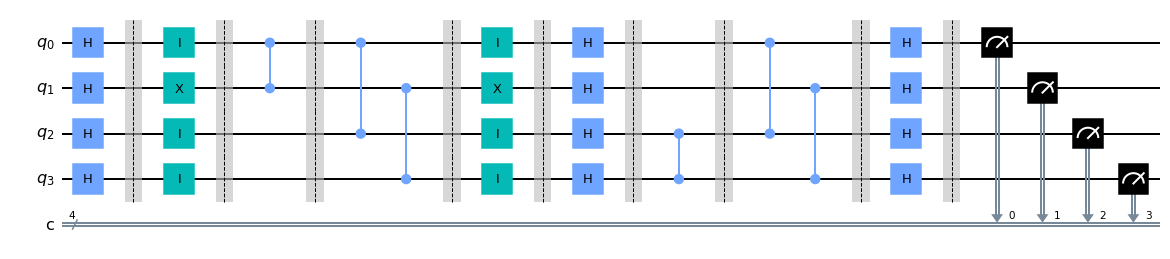

In [4]:
hsp_circuit = QuantumCircuit(n, n)

for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()
hsp_circuit.compose(oracle_shifted_f, inplace=True)
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()
hsp_circuit.compose(oracle_fourier_f, inplace=True)
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.measure(i, i)

hsp_circuit.draw('mpl')

### 3a. Experiment with Simulators  <a id='simulation'></a>

We can run the above circuit on the simulator. 

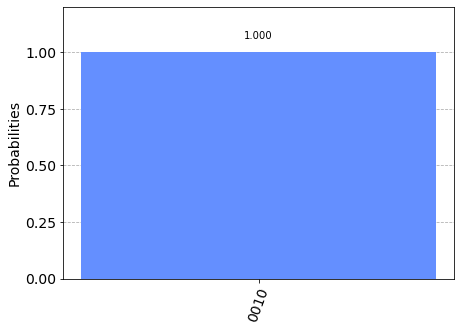

In [5]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the hidden string 0010.

## 4. Problems <a id='problems'> </a>

## 5. Breaking Poly1305 Encryption <a id="poly1305"> </a>

## 6. References <a id='references'> </a>

1. S. Bravyi & D. Gosset (2016), "Improved classical simulation of quantum circuits dominated by Clifford gates", Phys. Rev. Lett. 116, 250501, [doi:10.1103/PhysRevLett.116.250501](https://doi.org/10.1103/PhysRevLett.116.250501), [arXiv:1601.07601](https://arxiv.org/abs/1601.07601) [quant-ph]
2. M. Roetteler (2008), "Quantum algorithms for highly non-linear Boolean functions", Proceedings of the 21st Annual ACM-SIAM Symposium on Discrete Algorithms (SODA'10), pp. 448-457, [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) [quant-ph]
3. X. Bonnetain & M. Naya-Plasencia (2018), "Hidden Shift Quantum Cryptanalysis and Implications", In: T. Peyrin , S. Galbraith (eds) Advances in Cryptology – ASIACRYPT 2018, Lecture Notes in Computer Science, vol 11272, Springer, Cham, [doi:10.1007/978-3-030-03326-2_19](https://doi.org/10.1007/978-3-030-03326-2_19)
4. K. Wright, K. M. Beck, S. Debnath et al. (2019), "Benchmarking an 11-qubit quantum computer", Nat Commun 10, 5464, [doi:10.1038/s41467-019-13534-2](https://doi.org/10.1038/s41467-019-13534-2)